# Calibrating the HMETS hydrological model using OSTRICH on the Raven server

Here we use birdy's WPS client to calibrate the HMETS hydrological model on the server and analyze the calibrated parameter set and hydrograph. 

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

url = "http://localhost:9099/wps"
wps = WPSClient(url)

In [3]:
# The model parameter boundaries. Can either be a string of comma separated values, a list, an array or a named tuple. 
lowerBounds = '0.3, 0.01, 0.5, 0.15, 0.0, 0.0, -2.0, 0.01, 0.0, 0.01, 0.005, -5.0, \
                      0.0, 0.0, 0.0, 0.0, 0.00001, 0.0, 0.00001, 0.0, 0.0'
upperBounds = '20.0, 5.0, 13.0, 1.5, 20.0, 20.0, 3.0, 0.2, 0.1, 0.3, 0.1, 2.0, 5.0, \
                      1.0, 3.0, 1.0, 0.02, 0.1, 0.01, 0.5, 2.0'
          
# Forcing files
ts=TESTDATA['ostrich-hmets-nc-ts']

# OSTRICH configuration parameters
config = dict(
    algorithm='DDS',
    max_iterations=10,
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    lowerbounds=lowerBounds,
    upperbounds=upperBounds,
    start_date=dt.datetime(1954, 1, 1),
    duration=208,
    )

# Let's call Ostrich with the timeseries, calibration parameters and other configuration parameters
resp = wps.ostrich_hmets(ts=str(ts), **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[calibration, hydrograph, storage, solution, diagnostics, calibparams] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [4]:
print(calibparams)

[ 1.653174e+01  3.678551e+00  5.905587e+00  9.852317e-01  8.145660e+00
  9.192945e+00  2.810503e+00  4.716799e-02  8.181680e-02  1.660036e-01
  2.857117e-02 -1.762671e+00  5.025134e-02  5.668181e-01  9.193560e-01
  3.239183e-01  1.621145e-02  8.853951e-03  1.117335e-03  1.509350e-01
  4.396423e-01]


The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [4]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 209, nbasins: 1)>
array([[  0.      ],
       [ 81.069867],
       [155.109581],
       ...,
       [ 77.309924],
       [115.485875],
       [161.592978]])
Coordinates:
  * time        (time) datetime64[ns] 1954-01-01 1954-01-02 ... 1954-07-28
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

/home/ets/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


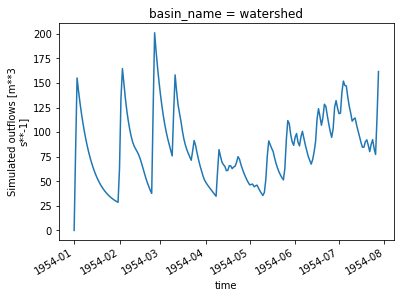

In [5]:
hydrograph.q_sim.plot()

In [6]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby('time.month').mean())

Max:  <xarray.DataArray 'q_sim' ()>
array(201.030086)
Mean:  <xarray.DataArray 'q_sim' ()>
array(84.175412)
Monthly means:  <xarray.DataArray 'q_sim' (month: 7)>
array([ 64.017862, 100.245198,  94.658255,  58.603366,  65.044782, 100.572446,
       109.827618])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7


/home/ets/miniconda3/lib/python3.7/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


## Here is the tricky part: How to extract the best parameter sets? The results are in "calibration", which is just a text file:

In [7]:
calibration

'--------------------------------------------------------------------------\n OSTRICH version 19.06.04 (Built Jun  4 2019 @ 23:17:50)\n\n A computer program for model-independent calibration and optimization.\n\n Author             L. Shawn Matott\n Copyright (C) 2007 L. Shawn Matott\n\n This program is free software; you can redistribute \n it and/or modify it under the terms of the GNU  \n General Public License as published by the Free \n Software Foundation; either version 2 of the \n License, or(at your option) any later version. \n\n This program is distributed in the hope that it will \n be useful, but WITHOUT ANY WARRANTY; without even \n the implied warranty of MERCHANTABILITY or FITNESS \n FOR A PARTICULAR PURPOSE. See the GNU General Public \n License for more details. \n\n You should have received a copy of the GNU General \n Public License along with this program; if not, \n write to the Free Software Foundation, Inc., 59 \n Temple Place, Suite 330, Boston, MA 02111-1307 U

## We would need some type of method to automate the extraction that is independent of the  hydrological model!